In [96]:
import numpy as np
import pandas as pd
from collections import defaultdict
import scipy
import scipy.sparse as sp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import cooler
import cooltools
import mirnylib
import mirnylib.plotting
from mirnylib.numutils import observedOverExpectedWithMask
import bioframe

import importlib as imp
import multiprocess as mp
import glob

import matrix_manager as mm
import DNA_info
import eigendecomposition

%matplotlib notebook

In [ ]:
genome = 'hg38'
res = 100000

# Plotting eigenvector Correlation Maps

## All celltypes

In [ ]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
table = mm.filter_data(table, filter_dict={'seq':['-','control'], 'cycle':'NS', 
                                           'enzyme':['DdeI','DpnII','HindIII', 'MNase']})
table = mm.get_compartments(table, res=100000)
table = table.sort_values(['celltype','enzyme','xlink']).reset_index(drop=True)
table

In [ ]:
celltype_dict = {x[1]:x[0] for x in enumerate(table.celltype.unique())}
enzyme_dict = {x[1]:x[0] for x in enumerate(table.enzyme.unique())}
xlink_dict = {x[1]:x[0] for x in enumerate(table.xlink.unique())}

corr_mat = np.empty((table.shape[0],table.shape[0]))
ct_vector = np.empty((table.shape[0],4))
xlink_vector = np.empty((table.shape[0],4))
enzyme_vector = np.empty((table.shape[0],4))

ct_cmap = matplotlib.cm.get_cmap('tab10')
enzyme_cmap = matplotlib.cm.get_cmap('Dark2')
xlink_cmap = matplotlib.cm.get_cmap('Set2')

for i, row1 in table.iterrows():
    
    vec1 = row1['vectors_100000']['E1_cis'].values
    ct_vector[i,:] = ct_cmap(celltype_dict[row1['celltype']])
    xlink_vector[i,:] = xlink_cmap(xlink_dict[row1['xlink']])
    enzyme_vector[i,:] = enzyme_cmap(enzyme_dict[row1['enzyme']])
    
    for j, row2 in table.iterrows():
        vec2 = row2['vectors_100000']['E1_cis'].values
        assert vec2.shape[0] == vec1.shape[0]
        mask = np.ones_like(vec1).astype(bool)
        mask = mask & (~np.isnan(vec1))
        mask = mask & (~np.isnan(vec2))
        
        v1 = vec1[mask]
        v2 = vec2[mask]
        
        corr = scipy.stats.spearmanr(v1, v2)[0]
        corr_mat[i, j] = corr
        
np.savetxt(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/compartments/eigenvector/eig_corr_data_all_celltype.txt',
            corr_mat, delimiter='\t', fmt='%2.2f')
ct_vector = np.transpose(np.dstack((ct_vector, ct_vector)), (0,2,1))
enzyme_vector = np.transpose(np.dstack((enzyme_vector, enzyme_vector)), (0,2,1))
xlink_vector = np.transpose(np.dstack((xlink_vector, xlink_vector)), (0,2,1))

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.suptitle('Spearman Correlation Matrix for Eigenvectors', fontsize=20, fontweight='bold')
gs = GridSpec(nrows=4, ncols=5, height_ratios=[5, 5, 5, 90], width_ratios=[5, 5, 5, 90, 1])
cmap='tab10'
#celltypes
ax0 = fig.add_subplot(gs[0,3])
ax0.set_title('Celltype: END, ESC, HFF, Hela')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.transpose(ct_vector, (1,0,2)), aspect='auto')
ax1 = fig.add_subplot(gs[3,0])
# ax1.set_ylabel('Celltype: END, ESC, HFF, Hela')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(ct_vector, aspect='auto')

#enzymes
ax0 = fig.add_subplot(gs[1,3])
ax0.set_title('Enzyme: DdeI, DpnII, HindIII, MNase')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.transpose(enzyme_vector, (1,0,2)))
ax1 = fig.add_subplot(gs[3,1])
# ax1.set_ylabel('Enzyme: DdeI, DpnII, HindIII, MNase')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(enzyme_vector)

#xlinkers
ax0 = fig.add_subplot(gs[2,3])
ax0.set_title('Crosslinker: DSG, EGS, FA')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.transpose(xlink_vector, (1,0,2)))
ax1 = fig.add_subplot(gs[3,2])
# ax1.set_ylabel('Crosslinker: DSG, EGS, FA')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(xlink_vector)

#correlation Matrix
axi = fig.add_subplot(gs[3,3])
axi.set_xticks([])
axi.set_yticks([])
img = axi.imshow(corr_mat, aspect='auto', cmap='fall', vmax=1, vmin=0)

cax = fig.add_subplot(gs[3,4])
cbar = plt.colorbar(img, cax=cax)

# fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/eigenvector_correlation_matrix.png')
# fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/eigenvector_correlation_matrix.pdf',format='pdf')

## One celltype

In [ ]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
celltype = 'END'
table = mm.filter_data(table, filter_dict={'celltype':celltype,'seq':['-','control'], 'cycle':'NS', 
                                           'enzyme':['DdeI','DpnII','HindIII', 'MNase']})
table = mm.get_compartments(table, res=100000)
table = table.sort_values(['enzyme','xlink']).reset_index(drop=True)
table

In [ ]:
enzyme_dict = {x[1]:x[0] for x in enumerate(table.enzyme.unique())}
xlink_dict = {x[1]:x[0] for x in enumerate(table.xlink.unique())}

corr_mat = np.empty((table.shape[0],table.shape[0]))
xlink_vector = np.empty((table.shape[0],4))
enzyme_vector = np.empty((table.shape[0],4))

enzyme_cmap = matplotlib.cm.get_cmap('Dark2')
xlink_cmap = matplotlib.cm.get_cmap('Set2')

for i, row1 in table.iterrows():
    
    vec1 = row1['vectors_100000']['E1_cis'].values
    xlink_vector[i,:] = xlink_cmap(xlink_dict[row1['xlink']])
    enzyme_vector[i,:] = enzyme_cmap(enzyme_dict[row1['enzyme']])
    
    for j, row2 in table.iterrows():
        vec2 = row2['vectors_100000']['E1_cis'].values
        assert vec2.shape[0] == vec1.shape[0]
        mask = np.ones_like(vec1).astype(bool)
        mask = mask & (~np.isnan(vec1))
        mask = mask & (~np.isnan(vec2))
        
        v1 = vec1[mask]
        v2 = vec2[mask]
        
        corr = scipy.stats.spearmanr(v1, v2)[0]
        corr_mat[i, j] = corr

np.savetxt(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/compartments/eigenvector/eig_corr_data_{celltype}.txt',
            corr_mat, delimiter='\t', fmt='%2.2f')
enzyme_vector = np.transpose(np.dstack((enzyme_vector, enzyme_vector)), (0,2,1))
xlink_vector = np.transpose(np.dstack((xlink_vector, xlink_vector)), (0,2,1))

In [ ]:
fig = plt.figure(figsize=(9,9))
fig.suptitle(f'Spearman Correlation Matrix for {celltype} Eigenvectors', fontsize=20, fontweight='bold')
gs = GridSpec(nrows=3, ncols=4, height_ratios=[5, 5, 90], width_ratios=[5, 5, 90, 1])

#enzymes
ax0 = fig.add_subplot(gs[0,2])
ax0.set_title('Enzyme: DdeI, DpnII, HindIII, MNase')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.transpose(enzyme_vector, (1,0,2)), aspect='auto')
ax1 = fig.add_subplot(gs[2,0])
# ax1.set_ylabel('Enzyme: DdeI, DpnII, HindIII, MNase')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(enzyme_vector, aspect='auto')

#xlinkers
ax0 = fig.add_subplot(gs[1,2])
ax0.set_title('Crosslinker: DSG, EGS, FA')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(np.transpose(xlink_vector, (1,0,2)), aspect='auto')
ax1 = fig.add_subplot(gs[2,1])
# ax1.set_ylabel('Crosslinker: DSG, EGS, FA')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(xlink_vector, aspect='auto')

#correlation Matrix
lim=0.8
axi = fig.add_subplot(gs[2,2])
axi.set_xticks([])
axi.set_yticks([])
img = axi.imshow(corr_mat, aspect='auto', cmap='fall', vmax=1, vmin=lim)

cax = fig.add_subplot(gs[2,3])
cbar = plt.colorbar(img, cax=cax)
cbar = plt.colorbar(img, cax=cax, ticks=[lim, np.round((lim+1)/2, 2), 1])
cax.set_yticklabels([f'<= {lim}', f'{np.round((lim+1)/2, 2)}', '1'])

fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/compartments/eigenvector/eigenvector_correlation_{celltype}.png')
fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/compartments/eigenvector/eigenvector_correlation_{celltype}.pdf',format='pdf')

# Marginals and compartments

In [8]:
imp.reload(mm)
ds = mm.Dataset()
table = ds.get_tables()
table = mm.filter_data(table, filter_dict={'seq':['-','control'], 'cycle':'NS', 
                                           'enzyme':['DdeI','DpnII','HindIII', 'MNase']})
table = mm.get_coolers(table, res=100000)
table = mm.get_compartments(table, res=100000)
table = table.sort_values(['celltype','enzyme','xlink']).reset_index(drop=True)
table

,lib_name,seq,celltype,xlink,enzyme,cycle,cooler_100000,lams_100000,vectors_100000
0,U54-END-DSG-DdeI-20161031-R1-T1__hg38,-,END,DSG,DdeI,NS,"<Cooler ""U54-END-DSG-DdeI-20161031-R1-T1__hg38...",eigval1 eig...,chrom start end gene_count g...
1,U54-END-EGS-DdeI-20161219-R1-T1__hg38,-,END,EGS,DdeI,NS,"<Cooler ""U54-END-EGS-DdeI-20161219-R1-T1__hg38...",eigval1 eig...,chrom start end gene_count g...
2,U54-END-FA-DdeI-20161118-R1-T1__hg38,-,END,FA,DdeI,NS,"<Cooler ""U54-END-FA-DdeI-20161118-R1-T1__hg38....",eigval1 eig...,chrom start end gene_count g...
3,U54-END-DSG-DpnII-20190711-R2-T1__hg38,-,END,DSG,DpnII,NS,"<Cooler ""U54-END-DSG-DpnII-20190711-R2-T1__hg3...",eigval1 eig...,chrom start end gene_count g...
4,U54-END-EGS-DpnII-20170119-R2-T1__hg38,-,END,EGS,DpnII,NS,"<Cooler ""U54-END-EGS-DpnII-20170119-R2-T1__hg3...",eigval1 eig...,chrom start end gene_count g...
5,U54-END-FA-DpnII-20170119-R2-T1__hg38,control,END,FA,DpnII,NS,"<Cooler ""U54-END-FA-DpnII-20170119-R2-T1__hg38...",eigval1 eig...,chrom start end gene_count g...
6,U54-END-DSG-HindIII-20161206-R1-T1__hg38,-,END,DSG,HindIII,NS,"<Cooler ""U54-END-DSG-HindIII-20161206-R1-T1__h...",eigval1 eig...,chrom start end gene_count g...
7,U54-END-EGS-HindIII-20161219-R1-T1__hg38,-,END,EGS,HindIII,NS,"<Cooler ""U54-END-EGS-HindIII-20161219-R1-T1__h...",eigval1 eig...,chrom start end gene_count g...
8,U54-END-FA-HindIII-20160311-R1-T1__hg38,-,END,FA,HindIII,NS,"<Cooler ""U54-END-FA-HindIII-20160311-R1-T1__hg...",eigval1 eig...,chrom start end gene_count g...
9,U54-END-DSG-MNase-20170508-R1-T1__hg38,control,END,DSG,MNase,NS,"<Cooler ""U54-END-DSG-MNase-20170508-R1-T1__hg3...",eigval1 eig...,chrom start end gene_count g...


In [157]:
chromsizes = bioframe.fetch_chromsizes('hg38')
cmap = cm.get_cmap('plasma')
for i, row in table.iterrows():
    if i != 30:
        continue
    print(row['lib_name'])
    cool = row['cooler_100000']
    pix = cool.pixels()[:]
    pix = pd.concat([pix, pix.rename(columns={'bin1_id':'bin2_id', 'bin2_id':'bin1_id'})])
    pix = pix.drop_duplicates().reset_index(drop=True)
    bins = cool.bins()[:]
    pix = cooler.annotate(pix, bins)
    vector = row['vectors_100000']
    pix['balanced'] = pix['count']*pix['weight1']*pix['weight2']
    full = pix.groupby('bin1_id').agg({'chrom1':'first', 'start1':'first','end1':'first', 
                                      'count':'sum', 'balanced':'sum'}).rename(columns={'chrom1':'chrom',
                                                                                       'start1':'start',
                                                                                       'end1':'end'})
    full = full.merge(vector[['chrom', 'start','end', 'E1_cis']], on=['chrom','start','end'], how='outer')
    
    cis = pix[pix['chrom1'] == pix['chrom2']]
    cis = cis.groupby('bin1_id').agg({'chrom1':'first', 'start1':'first','end1':'first', 
                                      'count':'sum', 'balanced':'sum'}).rename(columns={'chrom1':'chrom',
                                                                                       'start1':'start',
                                                                                       'end1':'end'})
    cis = cis.merge(vector[['chrom', 'start','end', 'E1_cis']], on=['chrom','start','end'], how='outer')
    
    trans = pix[pix['chrom1'] != pix['chrom2']]
    trans = trans.groupby('bin1_id').agg({'chrom1':'first', 'start1':'first','end1':'first', 
                                      'count':'sum', 'balanced':'sum'}).rename(columns={'chrom1':'chrom',
                                                                                       'start1':'start',
                                                                                       'end1':'end'})
    trans = trans.merge(vector[['chrom', 'start','end', 'E1_cis']], on=['chrom','start','end'], how='outer')
    
    break

U54-HFF-plate-DSG-HindIII-20160226-R1-T1__hg38


/home/sameer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




<IPython.core.display.Javascript object>


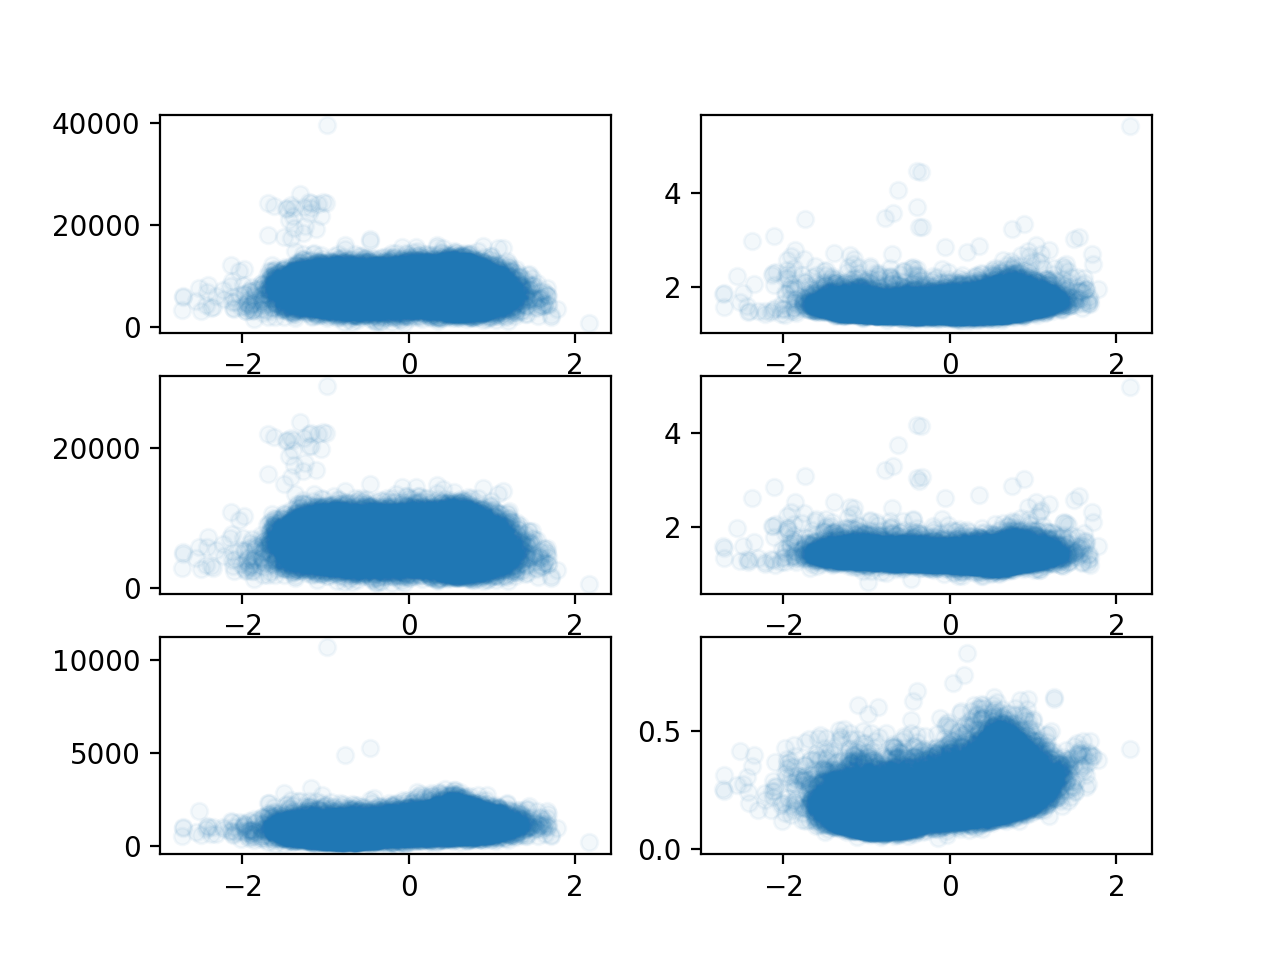

In [160]:
fig, ax = plt.subplots(nrows=3, ncols=2)
x = full['E1_cis_x'].values
y1 = full['count'].values
ax[0, 0].scatter(x,y1, alpha=0.05)
y2 = full['balanced'].values
ax[0, 1].scatter(x,y2, alpha=0.05)

x = cis['E1_cis'].values
y1 = cis['count'].values
ax[1, 0].scatter(x,y1, alpha=0.05)
y2 = cis['balanced'].values
ax[1, 1].scatter(x,y2, alpha=0.05)

x = trans['E1_cis'].values
y1 = trans['count'].values
ax[2, 0].scatter(x,y1, alpha=0.05)
y2 = trans['balanced'].values
ax[2, 1].scatter(x,y2, alpha=0.05)

In [110]:
def func(x):
    if x == 'chrX':
        return 4*23
    elif x == 'chrY':
        return 4*24
    elif x == 'chrM':
        return 4*25
    else:
        return 4*int(x[3:])

NameError: name 'mpl' is not defined